In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade imutils
!pip install playsound
!pip install pysoundfile
!pip install bitstring

  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7037 sha256=afa81d5429346914213352aa6326e8c20a5a9b0d624d8abe45bcacd30b68a00f
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


In [ ]:
import IPython

IPython.display.Audio('/content/drive/MyDrive/Colab Notebooks/alarm.wav')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


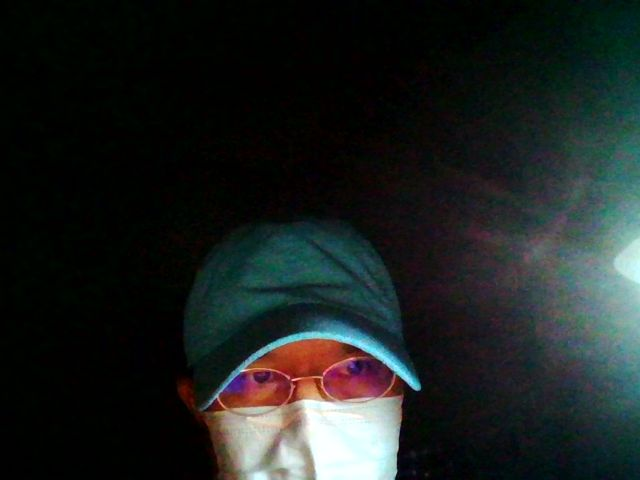

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# function to convert the JavaScript object into an OpenCV image

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  
# decode base64 image

  image_bytes = b64decode(js_reply.split(',')[1])
  
# convert bytes to numpy array

  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  
# decode numpy array into OpenCV BGR image

  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream

def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  
# convert array into PIL image

  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  
# format bbox into png for return

  bbox_PIL.save(iobuf, format='png')
  
# format return string

  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
# import the necessary packages
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
from threading import Thread
import numpy as np
import playsound
import argparse
import imutils
import time
import dlib
import cv2
import IPython


def sound_alarm(path):
	# play an alarm sound
	#playsound.playsound('/content/drive/MyDrive/Colab Notebooks/alarm.wav')
	IPython.display.Audio('/content/drive/MyDrive/Colab Notebooks/alarm.wav')
	
def eye_aspect_ratio(eye):
	# compute the distances between the sets of vertical eye landmarks (x, y)
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	# compute the distance between the horizontal eye landmark (x, y)
	C = dist.euclidean(eye[0], eye[3])
	# compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
	# return the eye aspect ratio
	return ear


# define two constants, one for the eye aspect ratio to indicate blink and then a second constant for the number of consecutive
# frames the eye must be below the threshold for to set off the alarm
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 48
# initialize the frame counter as well as a boolean used to indicate if the alarm is going off
img_data = ""
COUNTER = 0
ALARM_ON = False

# initialize dlib's face detector and create the facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')

# grab the indexes of the facial landmarks for the left and right eyes
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# start the video stream thread
print("[INFO] starting video stream ...")
#vs = VideoStream(src=args["webcam"]).start()
#vs = video_stream()
video_stream()
label = "Video Stream Capturing....."
#time.sleep(1.0)

# loop over frames from the video stream
while True:
	#grab the frame from the video stream, resize it, and convert it to grayscale channels
	#frame = vs.read()
	#frame = imutils.resize(frame, width=450)
	frame = video_frame(label, img_data)
	if not frame:
		break
 	#convert JS response to OpenCV Image
	frame = js_to_image(frame["img"])
	#create transparent overlay for bounding box
	

	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	
	# detect faces in the grayscale frame
	rects = detector(gray, 0)
	
# loop over the face detections
	for rect in rects:
		# determine the facial landmarks for the face region, then convert the facial landmark (x, y) to a NumPy array
		shape = predictor(gray, rect)
		shape = face_utils.shape_to_np(shape)
		# extract the left and right eye coordinates, use the coordinates to compute the eye aspect ratio for both eyes
		leftEye = shape[lStart:lEnd]
		rightEye = shape[rStart:rEnd]
		leftEAR = eye_aspect_ratio(leftEye)
		rightEAR = eye_aspect_ratio(rightEye)
		# average the eye aspect ratio together for both eyes
		ear = (leftEAR + rightEAR) / 2.0
		# compute the convex hull for the left and right eye, and visualize each of the eyes
		leftEyeHull = cv2.convexHull(leftEye)
		rightEyeHull = cv2.convexHull(rightEye)
		cv2.drawContours(np.float32(frame), [leftEyeHull], -1, (0, 255, 0), 1)
		cv2.drawContours(np.float32(frame), [rightEyeHull], -1, (0, 255, 0), 1)
		# check to see if the eye aspect ratio is below the blink threshold, and if so, increment the blink frame counter
		if ear < EYE_AR_THRESH:
			COUNTER += 1
			# if the eyes were closed for a sufficient number, then play the alarm
			if COUNTER >= EYE_AR_CONSEC_FRAMES:
				# if the alarm is not on, turn it on
				if not ALARM_ON:
					#ALARM_ON = True
					IPython.display.Audio('/content/drive/MyDrive/Colab Notebooks/alarm.wav')
		 
				
				# draw an alarm on the frame
				cv2.putText(frame, "DROWSINESS ALERT!", (10, 30),
					cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
		# otherwise, the eye aspect ratio is not below the blink threshold, reset the counter and alarm
		else:
			COUNTER = 0
			ALARM_ON = False
			
		# draw the computed eye aspect ratio on the frame to help
		# with debugging and setting the correct eye aspect ratio
		# thresholds and frame counters
		cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
			cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

#$ python detect_drowsiness.py --shape-predictor shape_predictor_68_face_landmarks.dat --alarm alarm.wav


[INFO] loading facial landmark predictor...
[INFO] starting video stream ...


<IPython.core.display.Javascript object>

'\n\tkey = cv2.waitKey(1) & 0xFF\n \n\t# if the `q` key was pressed, break from the loop\n\tif key == ord("q"):\n\t\tbreak\n# do a bit of cleanup\ncv2.destroyAllWindows()\nvs.stop()\n'